In [1]:
import numpy as np
import random
from math import exp, sqrt
from matplotlib import pyplot as plt

In [2]:
# COST FUNCTIONS
def time_diff_cost(traj, target_vehicle, delta, T, predictions):
    _, _, t = traj
    return logistic(abs(t-T))

def s_diff_cost(traj, target_vehicle, delta, T, predictions):
    s, _, _ = traj
    target = predictions[target_vehicle].state_in(T)
    s_targ = target[:3]
    cost = 0
    for actual, expected, sigma in zip(s, s_targ, SIGMA_S):
        diff = float(abs(actual-expected))
        cost += logistic(diff/sigma)
    return cost

def d_diff_cost(traj, target_vehicle, delta, T, predictions):
    _, d, _ = traj
    target = predictions[target_vehicle].state_in(T)
    d_targ = target[3:]
    cost = 0
    for actual, expected, sigma in zip(d, d_targ, SIGMA_D):
        diff = float(abs(actual-expected))
        cost += logistic(diff/sigma)
    return cost

def collision_cost(traj, target_vehicle, delta, T, predictions):
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    if nearest < 2*VEHICLE_RADIUS: return 1.0
    else : return 0.0
    pass

def buffer_cost(traj, target_vehicle, delta, T, predictions):
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    return logistic(2*VEHICLE_RADIUS / nearest)
    
def stays_on_road_cost(traj, target_vehicle, delta, T, predictions):
    pass

def exceeds_speed_limit_cost(traj, target_vehicle, delta, T, predictions):
    pass

def efficiency_cost(traj, target_vehicle, delta, T, predictions):
    s, _, t = traj
    s = to_equation(s)
    avg_v = float(s(t)) / t
    targ_s, _, _, _, _, _ = predictions[target_vehicle].state_in(t)
    targ_v = float(targ_s) / t
    return logistic(2*float(targ_v - avg_v) / avg_v)

def max_accel_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    total_acc = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        acc = a(t)
        total_acc += abs(acc*dt)
    acc_per_second = total_acc / T
    
    return logistic(acc_per_second / EXPECTED_ACC_IN_ONE_SEC )
    
def total_accel_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    all_accs = [a(float(T)/100 * i) for i in range(100)]
    max_acc = max(all_accs, key=abs)
    if abs(max_acc) > MAX_ACCEL: return 1
    else: return 0
    

def max_jerk_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk = to_equation(jerk)
    all_jerks = [jerk(float(T)/100 * i) for i in range(100)]
    max_jerk = max(all_jerks, key=abs)
    if abs(max_jerk) > MAX_JERK: return 1
    else: return 0

def total_jerk_cost(traj, target_vehicle, delta, T, predictions):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = to_equation(differentiate(s_d_dot))
    total_jerk = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        j = jerk(t)
        total_jerk += abs(j*dt)
    jerk_per_second = total_jerk / T
    
    return logistic(jerk_per_second / EXPECTED_JERK_IN_ONE_SEC )

In [3]:
SIGMA_S = [10.0, 4.0, 1.0] # s, s_dot, s_double_dot
SIGMA_D = [1.0, 1.0, 0.5]
SIGMA_T = 2.0

MAX_JERK = 10 # m/s/s/s
MAX_ACCEL= 10 # m/s/s

EXPECTED_JERK_IN_ONE_SEC = 2 # m/s/s
EXPECTED_ACC_IN_ONE_SEC = 1 # m/s

'''
WEIGHTED_COST_FUNCTIONS = [

    (time_diff_cost,    0),
    (s_diff_cost,       1),
    (d_diff_cost,       1),
    (efficiency_cost,   1),
    (max_jerk_cost,     0),
    (total_jerk_cost,   0),
    (collision_cost,    0),
    (buffer_cost,       0),
    (max_accel_cost,    0),
    (total_accel_cost,  0), 
   
]
'''

#'''
WEIGHTED_COST_FUNCTIONS = [

    (time_diff_cost,    1),
    (s_diff_cost,       3),
    (d_diff_cost,       3),
    (efficiency_cost,   1),
    (max_jerk_cost,     1),
    (total_jerk_cost,   5),
    (collision_cost,    10),
    (buffer_cost,       1),
    (max_accel_cost,    1),
    (total_accel_cost,  1),
]
#'''

N_SAMPLES = 10

SPEED_LIMIT = 30
VEHICLE_RADIUS = 1.5 # model vehicle as circle to simplify collision detection

In [4]:
def nearest_approach_to_any_vehicle(traj, vehicles):
    closest = 999999
    for v in vehicles.values():
        d = nearest_approach(traj,vehicle)
        if d < closest:
            closest = d
    return closest

def nearest_approach(traj, vehicle):
    closest = 999999
    s_,d_,T = traj
    s = to_equation(s_)
    d = to_equation(d_)
    for i in range(100):
        t = float(i) / 100 * T
        cur_s = s(t)
        cur_d = d(t)
        targ_s, _, _, targ_d, _, _ = vehicle.state_in(t)
        dist = sqrt((cur_s-targ_s)**2 + (cur_d-targ_d)**2)
        if dist < closest:
            closest = dist
    return closest

In [5]:
def logistic(x):
    return 2.0 / (1 + exp(-x)) - 1.0



def PTG(start_s, start_d, target_vehicle, delta, T, predictions):
    target = predictions[target_vehicle]
    # generate alternative goals
    all_goals = []
    timestep = 0.5
    t = T - 4 * timestep
    while t <= T + 4 * timestep:
        target_state = np.array(target.state_in(t)) + np.array(delta)
        goal_s = target_state[:3]
        goal_d = target_state[3:]
        goals = [(goal_s, goal_d, t)]
        for _ in range(N_SAMPLES):
            perturbed = perturb_goal(goal_s, goal_d)
            goals.append((perturbed[0], perturbed[1], t))
        all_goals += goals
        t += timestep
    
    # find best trajectory
    trajectories = []
    for goal in all_goals:
        s_goal, d_goal, t = goal
        s_coefficients = JMT(start_s, s_goal, t)
        d_coefficients = JMT(start_d, d_goal, t)
        trajectories.append(tuple([s_coefficients, d_coefficients, t]))
    
    best = min(trajectories, key=lambda tr: calculate_cost(tr, target_vehicle, delta, T, predictions, WEIGHTED_COST_FUNCTIONS))
    return best
    

def calculate_cost(trajectory, target_vehicle, delta, goal_t, predictions, cost_functions_with_weights ):
    cost = 0
    for cf, weight in cost_functions_with_weights:
        cost += weight * cf(trajectory, target_vehicle, delta, goal_t, predictions)
    return cost

def perturb_goal(goal_s, goal_d):
    new_s_goal = []
    for mu, sig in zip(goal_s, SIGMA_S):
        new_s_goal.append(random.gauss(mu, sig))

    new_d_goal = []
    for mu, sig in zip(goal_d, SIGMA_D):
        new_d_goal.append(random.gauss(mu, sig))
        
    return tuple([new_s_goal, new_d_goal])

In [6]:
class Vehicle(object):
    def __init__(self, start):
        self.start_state = start
    
    def state_in(self, t):
        s = self.start_state[:3]
        d = self.start_state[3:]
        state = [
            s[0] + (s[1] * t) + s[2] * t**2 / 2.0,
            s[1] + s[2] * t,
            s[2],
            d[0] + (d[1] * t) + d[2] * t**2 / 2.0,
            d[1] + d[2] * t,
            d[2],
        ]
        return state

In [7]:
def JMT(start, end, T):
    a_0, a_1, a_2 = start[0], start[1], start[2] / 2.0
    c_0 = a_0 + a_1 * T + a_2 * T**2
    c_1 = a_1 + a_2 * T
    c_2 = 2 * a_2
    
    A = np.array([
            [  T**3,   T**4,    T**5],
            [3*T**2, 4*T**3,  5*T**4],
            [6*T,   12*T**2, 20*T**5],
        ])
    B = np.array([
            end[0] - c_0,
            end[1] - c_1,
            end[2] - c_2
        ])
    a_3_4_5 = np.linalg.solve(A,B)
    alphas = np.concatenate([np.array([a_0, a_1, a_2]), a_3_4_5])
    return alphas

def to_equation(coefficients):
    def f(t):
        total = 0.0
        for i, c in enumerate(coefficients): 
            total += c * t ** i
        return total
    return f

def differentiate(coefficients):
    new_cos = []
    for deg, prev_co in enumerate(coefficients[1:]):
        new_cos.append((deg+1) * prev_co)
    return new_cos

def show_trajectory(s_coeffs, d_coeffs, T, vehicle=None):
    s = to_equation(s_coeffs)
    d = to_equation(d_coeffs)
    X = []
    Y = []
    if vehicle:
        X2 = []
        Y2 = []
    t = 0
    while t <= T:
#         t = float(T) / 20 * i
        X.append(s(t))
        Y.append(d(t))
        if vehicle:
            s_, _, _, d_, _, _ = vehicle.state_in(t)
            X2.append(s_)
            Y2.append(d_)
        t += 0.25
    plt.scatter(X,Y)
    if vehicle:
        plt.scatter(X2, Y2)
    plt.show()

In [8]:
vehicle = Vehicle([0,10,0, 0,0,0])
predictions = {0: vehicle}
target = 0
delta = [-5, 0, 0, 0, 0 ,0]
start_s = [10, 10, 0]
start_d = [4, 0, 0]
T = 5.0

In [9]:
best = PTG(start_s, start_d, target, delta, T, predictions)

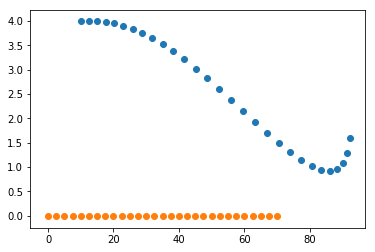

In [10]:
show_trajectory(best[0], best[1], best[2], vehicle)

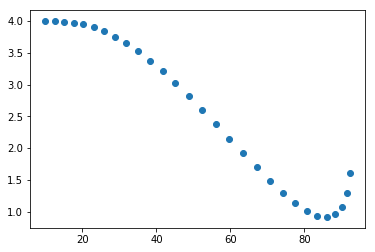

In [11]:
show_trajectory(best[0], best[1], best[2])